## plot spatial ACC pattern of DPLE

In [1]:
import matplotlib.colors as colors
from matplotlib import cm,gridspec,rc
import matplotlib.pyplot as plt
import os
import utils
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import corrstats
warnings.filterwarnings('ignore')

# Model Grid for region mask to remove values that are not good

In [2]:
USER = os.environ['USER']

In [3]:
path = f'/glade/u/home/{USER}/O2prediction/Prediction/notebooks/data'
filename = f'{path}/grid-data-POP_gx1v6.nc'
grid = xr.open_dataset(filename)
region_mask = grid['REGION_MASK']
#lon = grid.coords['TLONG']
#lat = grid.coords['TLAT']

In [4]:
path = f'/glade/work/{USER}/MAPP/ETOPO'
filename = f'{path}/Etopo1_Bed_0_65N_170E_40W.nc'
bathy = xr.open_dataset(filename)
lon_e = bathy['lon']
for ii in range(len(lon_e)):
    if lon_e[ii] > 0:
        lon_e[ii] = lon_e[ii] - 360.
lat_e = bathy['lat'][300:]
depth_e = bathy['depth'][300:, :]

In [5]:
mask_bathy = (depth_e >= 0.)*1.
mask_bathy = np.ma.array(mask_bathy,mask=mask_bathy==0.)
lon_e,lat_e = np.meshgrid(lon_e,lat_e)
lon_e = np.ma.array(lon_e,mask=mask_bathy.mask)
lat_e = np.ma.array(lat_e,mask=mask_bathy.mask)

In [8]:
lat_min = 15;   lat_max = 65
lon_min = -190; lon_max = -40
#
cmin = 0.;cmax = 1.;clev = 25.
dc = (cmax - cmin)/clev; vct = np.arange(cmin, cmax+dc, dc)
pal_normt = colors.BoundaryNorm(vct, ncolors=256, clip = False)
# text
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
#csfont = {'fontname':'Times New Roman'}

## LME Shapes

In [10]:
path = f'/glade/u/home/{USER}/O2prediction/Prediction/notebooks/data'
filename = '%s/LME_shapes.gmt' % path
file1 = open(filename,'r')
lines = file1.readlines()
#
nbox = -1
lonn = [[] for ii in range(194)]
latt = [[] for ii in range(194)]
ln = 9
for line in lines[ln:]:
    sl = line.split()
    if len(sl)==2 and sl[0] == '#':
        nbox = nbox + 1
    elif len(sl)==2 and sl[0] != '#':
        lonn[nbox-1].append(np.float(sl[0]))
        latt[nbox-1].append(np.float(sl[1]))
##
pp180 = []
for pp in range(len(lonn)):
    if len(lonn[pp])>0:
        if np.min(lonn[pp])>0:
            lon1 = np.array(lonn[pp]) - 360.
        else:
            lon1 = np.array(lonn[pp])
        if len(np.where(np.abs(lon1 + 180.)<1e-4)[0])>0:
            if len(lonn[pp])<4:
                pp180.append(pp)
##
lon0 = []
lat0 = []
nn = 0
for pp in range(len(lonn)):
    if len(lonn[pp])!=0:
        nn = nn + 1
        if np.min(lonn[pp])>0:
            lon1 = np.array(lonn[pp]) - 360.
        else:
            lon1 = np.array(lonn[pp])
        lat1 = np.array(latt[pp])
        lon1 = np.ma.array(lon1,mask=False)
        lat1 = np.ma.array(lat1,mask=False)
        if pp in pp180[1:]:
#        if len(np.where(np.abs(lon1+180.)<1e-4)[0]) > 0:
            #print(pp)
            aa = np.where(np.abs(lon1+180.)<1e-4)[0]
            lon1.mask[aa] = True
            lat1.mask[aa] = True
        lon0.append(lon1)
        lat0.append(lat1)

In [11]:
def mask_nan(var):
    """
    mask nan values
    """
    maskn = np.isnan(var)
    var = np.ma.array(var,mask=maskn)
    return var

-0.6586017372325699 0.9987308820500688
-0.7403557937792252 0.9894196052399741
-0.6083831796567926 0.9657620364419931
-0.6962287582098196 0.9495843467916217
-0.5991873072772753 0.9177792843725452
-0.9645544551573657 0.9390323785687842
-0.9255959792204022 0.889994542630266
-0.8941514643053043 0.8009993996181035
-0.9045263615770773 0.7777107684791105
-0.8974109509312929 0.8438972114633535
-0.9312256064184596 0.832787128298952
-0.9137222918143254 0.7923599665203109
-0.8471489850748057 0.6972125351948018
-0.8381279237014104 0.79890471525885
-0.8013641744394949 0.8225667319138334
-0.3704345159756562 0.9993409590322971
-0.4178170314031148 0.9980963211677043
-0.4849366894409277 0.9958665292586113
-0.6930482073982445 0.9934114881581714
-0.7595149639839768 0.9856400397027131
-0.962422341232569 0.9908549584247862
-0.9635174852878282 0.9714657064670296
-0.9066785144280559 0.9773467312605448
-0.9281539407720842 0.9746208084424547
-0.9343050594293416 0.9567190363219988
-0.9623739427710075 0.96016430

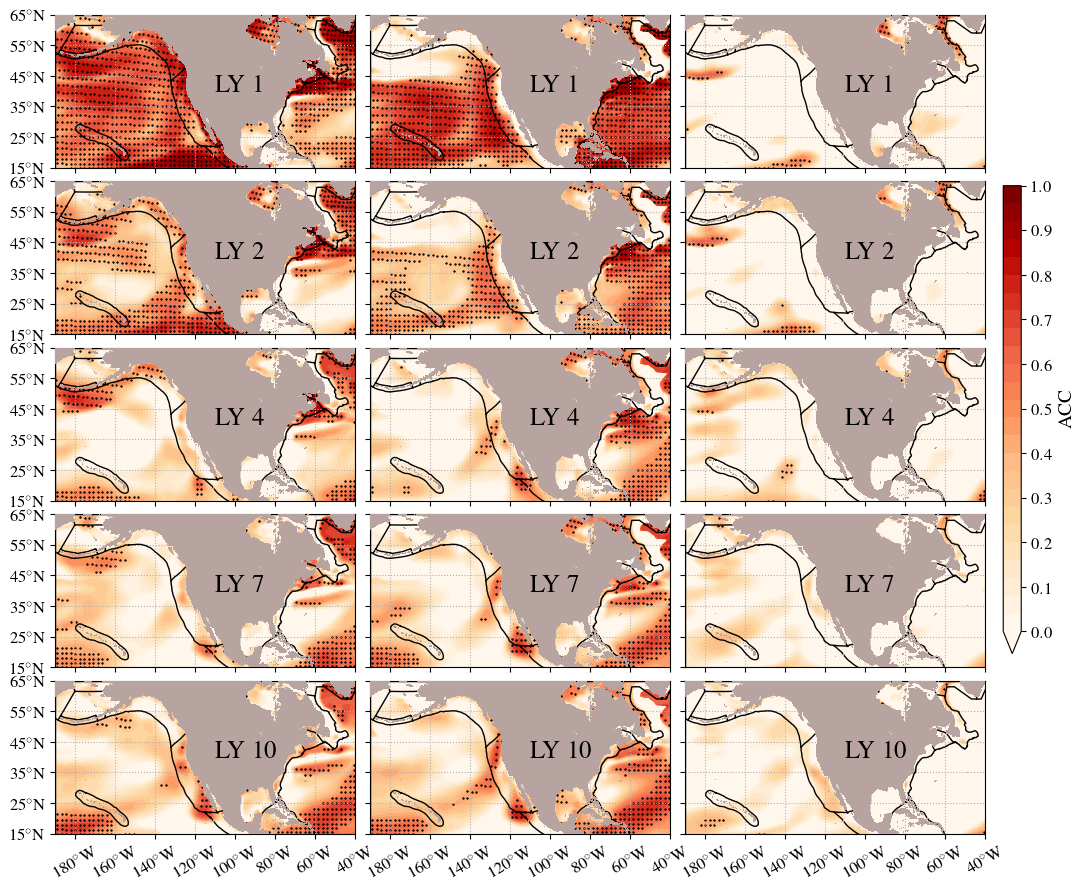

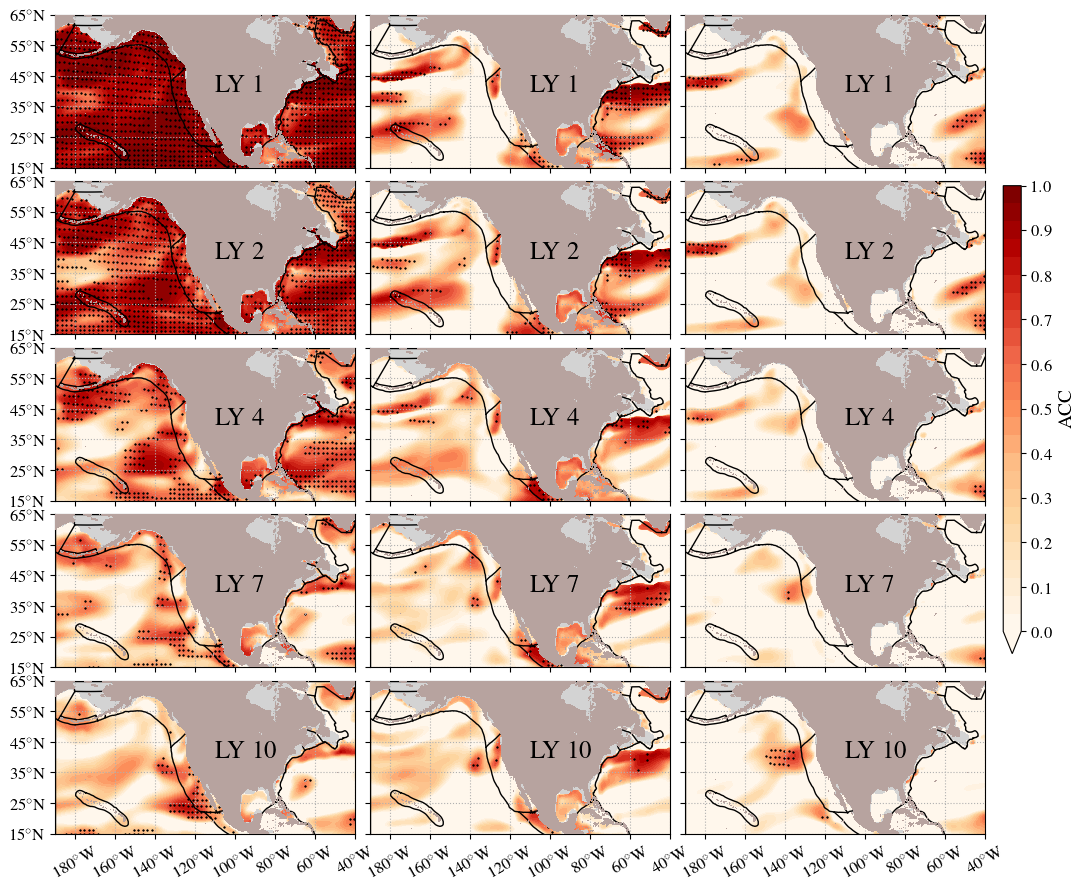

In [13]:
var = 'Phi'
datadir = f'/glade/scratch/{USER}/DPLE-results'
lyy = np.array([0, 1, 3, 6, 9])
#
nphi = 2
for layer in ['0-200m', '200-600m']:
    fig = plt.figure(figsize=[12, 9])
    gs = gridspec.GridSpec(5, 3)#, width_ratios=[1, 1, 1, 1e-2])
    for mm,varr,vas in [[0,'O2','O_2'],[1,'TEMP','T'],[2,'SALT','S']]:
        # read ACC data
        # Persistence and DPLE ACC
        filename = f'{datadir}/DPLE_spatial_persistence_DPLE_ACC_{var}_components_{varr}_{layer}_leadyear1-10_new_method2.nc'
        ds_fore = xr.open_dataset(filename)
        corr_p = ds_fore['corr_p'].values[nphi, :]
        rcri_p = ds_fore['rcri_p'].values[nphi, :]
        corr_d = ds_fore['corr_d'].values[nphi, :]
        rcri_d = ds_fore['rcri_d'].values[nphi, :]
        corr13 = ds_fore['corr13'].values[nphi, :]
        rcri13 = ds_fore['rcri13'].values[nphi, :]
        lon = ds_fore['lon'].values
        lat = ds_fore['lat'].values
        #
        corr_p = mask_nan(corr_p);rcri_p = mask_nan(rcri_p)
        corr_d = mask_nan(corr_d);rcri_d = mask_nan(rcri_d)
        corr13 = mask_nan(corr13);rcri13 = mask_nan(rcri13)
        #
        corr_f = corr_d - corr_p
        #
        pmask = corr_p > rcri_p
        # Test ACC difference significance
        lenn = 2007+1-1954
        t_cr, p_cr = corrstats.dependent_corr(corr_p, corr_d, corr13, lenn-1, twotailed=False, method='steiger')
        #
        alpha = 0.05
        smask = p_cr <= alpha
        maskk = corr_d > rcri_d
        maskp = corr_f > 0.
        ## plot
        for gg, ldd in zip(range(5), lyy):
        #for vv, mm, tit in [[corr_p, 0, 'Persistence'], [corr_d, 1, 'DPLE'], [corr_f, 2, 'ACC Difference']]:
            vv = corr_d
            tit = 'DPLE'
            ## persistence lead year 1-5
            ## DPLE lead year 1-5
            ## DPLE - persistence difference
            ax = fig.add_axes([0.08+mm*0.2625, 0.05+(4-gg)*0.185, 0.25, 0.17])
            #
            xrr = np.arange(lon_min-10, lon_max+10)
            ax.fill_between(xrr, np.ones(len(xrr))*(lat_min-10), np.ones(len(xrr))*(lat_max+10), color='lightgray')
            for pp in range(len(lon0)):
                ax.plot(lon0[pp], lat0[pp], color='k', linewidth=1., zorder=19)
            cd = ax.contourf(lon, lat, vv[ldd], vct, shading='nearest', cmap=new_cmapt, norm=pal_normt, extend='min')
            print(vv[ldd].min(), vv[ldd].max())
            lon1 = np.ma.array(lon, mask=~maskk[ldd])
            lat1 = np.ma.array(lat, mask=~maskk[ldd])
            ax.scatter(lon1[::4, ::2], lat1[::4, ::2], s=5, marker='.', color='k', alpha=1, linewidth=.5)
            ax.pcolor(lon_e,lat_e,mask_bathy,shading='nearest',cmap=cm.terrain_r,vmin=.5,vmax=4,zorder=20)
            ax.text(-110, 40, 'LY %d' % (ldd+1), fontsize=18, fontweight='bold', zorder=21)
            ax.set_xlim(lon_min, lon_max)
            ax.set_ylim(lat_min, lat_max)
            ax.set_xticks(np.arange(-180, -30, 20))
            ax.set_yticks(np.arange(15, 66, 10))
            #
            xtl = []
            for ii in np.arange(-180, -30, 20):
                if ii < -180:
                    ii = ii + 360
                    ff = 'E'
                elif ii >= -180:
                    ff = 'W'
                elif np.abs(ii-0) < 1e-5:
                    ff = ''
                xtl.append('%d$^\circ$%s' % (abs(ii), ff))
            ytl = []
            for jj in np.arange(15, 66, 10):
                if jj < 0:
                    ff = 'S'
                elif jj > 0:
                    ff = 'N'
                elif np.abs(jj-0) < 1e-5:
                    ff = ''
                ytl.append('%d$^\circ$%s' % (abs(jj), ff))
            if gg == 4:
                ax.set_xticklabels(xtl, fontsize=12, fontweight='bold', rotation=30)
            else:
                ax.set_xticklabels([], fontsize=12, fontweight='bold', rotation=30)
            if mm == 0:
                ax.set_yticklabels(ytl, fontsize=12, fontweight='bold')
            else:
                ax.set_yticklabels([], fontsize=12, fontweight='bold')
            ax.plot([lon_min, lon_max], [lat_max, lat_max], color='k', linewidth=1, zorder=10)
            ax.plot([lon_min, lon_min], [lat_min, lat_max], color='k', linewidth=1, zorder=10)
            ax.grid(linestyle='dotted', zorder=11)
        # colorbar
            if gg == 0 and mm == 1:
                cbaxes = fig.add_axes([0.87, 0.25, 0.015, 0.52])
                cb = plt.colorbar(cd, orientation="vertical", label='ACC', cax=cbaxes, extend='min', ticks=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
                cb.ax.tick_params(labelsize=12)
                cb.set_label(label='ACC', fontsize=14, fontweight='bold')
    #
    output = f'/glade/scratch/{USER}/DPLE-plots'
    outfile = f'{output}/DPLE_ACC_spatial_O2_T_S_components_{var}_{nphi}_{layer}.png'
    plt.savefig(outfile, dpi=400, transparent=True)
plt.show()

## 